Financial Risk Data - Large
src : https://www.kaggle.com/datasets/deboleenamukherjee/financial-risk-data-large
columns : 51 columns

In [128]:
!pip install pip==23.2.1 setuptools==65.5.1

In [129]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [130]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "financial_risk_analysis_large.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/financial_risk_analysis_large.csv


In [131]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [132]:
# Load dataset
df = pd.read_csv(data_location)
df.head(5)

,CreditScore,AnnualIncome,LoanAmount,LoanDuration,Age,EmploymentStatus,MaritalStatus,NumberOfDependents,EducationLevel,HomeOwnershipStatus,...,JobTenure,MonthlySavings,AnnualBonuses,AnnualExpenses,MonthlyHousingCosts,MonthlyTransportationCosts,MonthlyFoodCosts,MonthlyHealthcareCosts,MonthlyEntertainmentCosts,LoanApproved
0,402,63295,18830,13,29,Self-Employed,Widowed,2,Doctorate,Other,...,24,378,3741,40058,977,412,399,136,124,0
1,735,55936,23729,1,42,Self-Employed,Divorced,3,Master,Own,...,10,575,4115,16745,695,206,898,252,131,0
2,570,62547,19660,7,54,Self-Employed,Single,3,Doctorate,Mortgage,...,16,691,4105,23273,627,266,392,73,36,0
3,406,46129,21674,23,25,Self-Employed,Divorced,3,High School,Other,...,6,452,4559,42163,397,307,250,378,-32,0
4,371,57725,12189,26,42,Employed,Widowed,4,Master,Own,...,2,690,7856,30087,723,315,114,88,68,0


In [133]:
df.shape

(1000000, 51)

In [134]:
df.columns

Index(['CreditScore', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'Age',
       'EmploymentStatus', 'MaritalStatus', 'NumberOfDependents',
       'EducationLevel', 'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'InterestRate', 'PaymentHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance',
       'InvestmentAccountBalance', 'RetirementAccountBalance',
       'EmergencyFundBalance', 'TotalAssets', 'TotalLiabilities', 'NetWorth',
       'LengthOfCreditHistory', 'MortgageBalance', 'RentPayments',
       'AutoLoanBalance', 'PersonalLoanBalance', 'StudentLoanBalance',
       'UtilityBillsPaymentHistory', 'HealthInsuranceStatus',
       'LifeInsuranceStatus', 'CarInsuranceStatus', 'HomeInsuranceStatus',
       'OtherInsurancePolicies', 'EmployerType', 'JobTenure', 'MonthlySavings',
       'AnnualB

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CreditScore                 1000000 non-null  int64  
 1   AnnualIncome                1000000 non-null  int64  
 2   LoanAmount                  1000000 non-null  int64  
 3   LoanDuration                1000000 non-null  int64  
 4   Age                         1000000 non-null  int64  
 5   EmploymentStatus            1000000 non-null  object 
 6   MaritalStatus               1000000 non-null  object 
 7   NumberOfDependents          1000000 non-null  int64  
 8   EducationLevel              1000000 non-null  object 
 9   HomeOwnershipStatus         1000000 non-null  object 
 10  MonthlyDebtPayments         1000000 non-null  int64  
 11  CreditCardUtilizationRate   1000000 non-null  float64
 12  NumberOfOpenCreditLines     1000000 non-null  int64  
 13

In [136]:
df.duplicated().sum()

0

In [137]:
df.isnull().sum()

CreditScore                   0
AnnualIncome                  0
LoanAmount                    0
LoanDuration                  0
Age                           0
EmploymentStatus              0
MaritalStatus                 0
NumberOfDependents            0
EducationLevel                0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
InterestRate                  0
PaymentHistory                0
SavingsAccountBalance         0
CheckingAccountBalance        0
InvestmentAccountBalance      0
RetirementAccountBalance      0
EmergencyFundBalance          0
TotalAssets                   0
TotalLiabilities              0
NetWorth                      0
LengthOfCreditHistory         0
MortgageBalance               0
RentPayments                  0
AutoLoan

In [138]:
df["LoanApproved"].value_counts()
df["LoanApproved"].value_counts(normalize=True) * 100

0    62.6831
1    37.3169
Name: LoanApproved, dtype: float64

/tmp/ipykernel_20374/3160062249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="LoanApproved", data=df, palette="Set2")


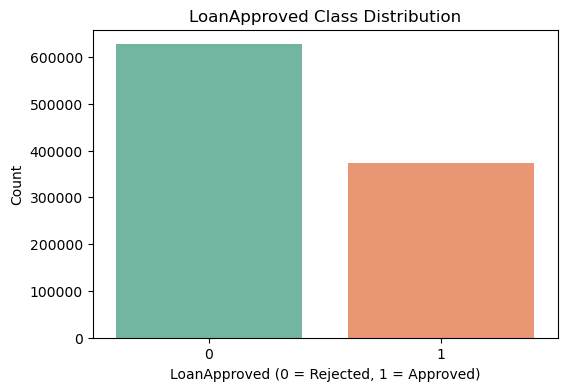

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x="LoanApproved", data=df, palette="Set2")
plt.title("LoanApproved Class Distribution")
plt.xlabel("LoanApproved (0 = Rejected, 1 = Approved)")
plt.ylabel("Count")
plt.show()

In [140]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separate features and target
X = df.drop("LoanApproved", axis=1)
y = df["LoanApproved"]

# Initialize undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling
X_res, y_res = rus.fit_resample(X, y)

# Check new class distribution
print("Original:", Counter(y))
print("Resampled:", Counter(y_res))


Original: Counter({0: 626831, 1: 373169})
Resampled: Counter({0: 373169, 1: 373169})


In [141]:
# Get unique values and their counts in the resampled target variable (y_res)
unique_y_res_counts = y_res.value_counts()
print("Unique values and counts in y_res:\n", unique_y_res_counts)

# Get unique values and their counts for each feature in the resampled features (X_res)
unique_X_res_counts = {}
for column in X_res.columns:
    unique_X_res_counts[column] = X_res[column].value_counts()

# Check unique values and counts in each column of X_res
for column, value_counts in unique_X_res_counts.items():
    print(f"Unique values and counts in {column}:\n {value_counts.head()}")  # Showing only the first 5 for brevity


Unique values and counts in y_res:
 0    373169
1    373169
Name: LoanApproved, dtype: int64
Unique values and counts in CreditScore:
 508    1621
577    1608
521    1607
678    1606
813    1597
Name: CreditScore, dtype: int64
Unique values and counts in AnnualIncome:
 60336    37
53002    37
56793    36
57654    36
64235    35
Name: AnnualIncome, dtype: int64
Unique values and counts in LoanAmount:
 19143    92
17908    87
20453    87
18540    86
19079    84
Name: LoanAmount, dtype: int64
Unique values and counts in LoanDuration:
 21    26208
18    26034
28    26016
29    25981
10    25945
Name: LoanDuration, dtype: int64
Unique values and counts in Age:
 38    14617
56    14615
64    14538
22    14532
60    14502
Name: Age, dtype: int64
Unique values and counts in EmploymentStatus:
 Unemployed       248990
Employed         248756
Self-Employed    248592
Name: EmploymentStatus, dtype: int64
Unique values and counts in MaritalStatus:
 Single      186972
Married     186790
Divorced    1

In [142]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: Identify categorical columns (object dtype)
categorical_columns = X_res.select_dtypes(include=['object']).columns

# Step 2: Label encode all categorical columns
le = LabelEncoder()
for column in categorical_columns:
    X_res[column] = le.fit_transform(X_res[column])

# Now X_res is fully numerical:
# - Categorical columns are label encoded
# - Numerical columns are untouched
print("✅ Preprocessing complete. Here's a preview:")
print(X_res.head())


✅ Preprocessing complete. Here's a preview:
        CreditScore  AnnualIncome  LoanAmount  LoanDuration  Age  \
428899          356         56568       20026            25   22   
644855          306         75066       16417             6   51   
582815          409         85834       21067             9   49   
457302          811         53257       25283             8   39   
890644          758         36345       16264            10   61   

        EmploymentStatus  MaritalStatus  NumberOfDependents  EducationLevel  \
428899                 1              2                   3               2   
644855                 0              0                   0               3   
582815                 2              2                   3               1   
457302                 1              0                   3               4   
890644                 2              3                   0               3   

        HomeOwnershipStatus  ...  EmployerType  JobTenure  MonthlySaving

In [143]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Check the shape of the split data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (597070, 50)
X_test shape: (149268, 50)
y_train shape: (597070,)
y_test shape: (149268,)


# FInd Algorithem = HistGradientBoosting 

In [172]:
import random
import math
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt




In [173]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [175]:

# DEAP setup for GA (unchanged)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using HistGradientBoosting with optimized parameters"""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    # Optimized HistGradientBoosting parameters
    # In your evaluation function (called by self.func in WOA), ensure you're using:
    model = HistGradientBoostingRegressor(
        max_leaf_nodes=31,
        learning_rate=0.1,
        min_samples_leaf=20,
        max_iter=100,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        scoring='neg_mean_squared_error',
        random_state=42,
        verbose=0
)

    # Train model
    model.fit(X_train.iloc[:, selected_indices], y_train)
    
    return mean_squared_error(y_test, model.predict(X_test.iloc[:, selected_indices]))

## 2. CUSTOM WHALE OPTIMIZATION ALGORITHM

In [171]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

## 3. SQUID GAME OPTIMIZER (SGO) IMPLEMENTATION

In [148]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [149]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

## ALGORITHM IMPLEMENTATIONS (ONE-BY-ONE)

In [176]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using HistGradientBoosting\n")  # Changed to HistGradientBoosting

    # 2. Setup evolutionary toolbox 
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                    toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))  # Uses HistGradientBoosting
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence (HistGradientBoosting)')  # Updated title
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [177]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using HistGradientBoosting\n")  # Updated model reference

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Uses HistGradientBoosting

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence (HistGradientBoosting)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [178]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using HistGradientBoosting\n")  # Updated model reference

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Uses HistGradientBoosting
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)
                a2 = -1 + iter * (-1 / self.max_iter)

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    whales[i] = np.clip(whales[i], self.lb, self.ub)
                    fitness[i] = self.func(whales[i])

                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence (HistGradientBoosting)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }

In [179]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using HistGradientBoosting\n")  # Updated model reference

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # Uses HistGradientBoosting

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence (HistGradientBoosting)')  # Updated title
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [180]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization with HistGradientBoosting specification
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20") 
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using HistGradientBoosting\n")  # Updated model reference

    # 2. Setup bounds and tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. HistGradientBoosting evaluation function
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)  # HistGradientBoosting evaluation
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite optimizer (unchanged structure)
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3

        def hypersphere_sampling(self, center, radius, n_samples):
            """Efficient hypersphere sampling with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Prevent division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize with boundary checking
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                radius = initial_radius * (1 - iter/self.max_iter)  # Linear decay
                
                # Vectorized hypersphere sampling
                new_points = np.vstack([self.hypersphere_sampling(p, radius, self.hs_samples) 
                                    for p in points])
                
                # Parallel evaluation
                new_fitness = np.array([self.func(p) for p in new_points])

                # Elite selection
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]
                
                # Update best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Progress reporting
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                        end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Execute optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-processing with min 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)

    # 7. Results reporting
    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Enhanced visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence (HistGradientBoosting)')  # Updated title
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [181]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor  # Changed from lightgbm
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results using HistGradientBoosting.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name} with HistGradientBoosting...")  # Updated model reference
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms using HistGradientBoosting"""
    plt.figure(figsize=(15, 10))
    plt.suptitle('Algorithm Comparison (HistGradientBoosting Evaluation)', y=1.02)  # Updated title

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'steelblue' for name in names]
    bars = plt.bar(names, mses, color=colors)
    plt.title('Model Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    bars = plt.bar(names, times, color=colors)
    plt.title('Computational Efficiency')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    bars = plt.bar(names, feature_counts, color=colors)
    plt.title('Feature Selection Sparsity')
    plt.ylabel('Number of Selected Features')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            linewidth = 3 if name == best_algo_name else 1.5
            linestyle = '-' if name == best_algo_name else '--'
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=linewidth,
                    linestyle=linestyle)
    plt.title('Convergence Patterns')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Enhanced summary report
    print("\n" + "="*60)
    print("=== FINAL FEATURE SELECTION RESULTS USING HistGradientBoosting ===")
    print("="*60)
    
    # Best algorithm summary
    print(f"\n🏆 BEST ALGORITHM: {best_algo_name.upper()}")
    print(f"   • MSE: {results[best_algo_name]['mse']:.6f}")
    print(f"   • Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"   • Features: {len(results[best_algo_name]['features'])}/{X_train.shape[1]} "
          f"({100*(1 - len(results[best_algo_name]['features'])/X_train.shape[1]):.1f}% reduction)")
    
    # Full comparison table
    print("\n📊 COMPARISON TABLE:")
    print(f"{'Algorithm':<30}{'MSE':<15}{'Time (s)':<15}{'Features':<15}")
    print("-"*75)
    for name in sorted(results.keys(), key=lambda x: results[x]['mse']):
        print(f"{name:<30}{results[name]['mse']:<15.6f}{results[name]['time']:<15.2f}"
              f"{len(results[name]['features']):<15}")

    # Selected features
    print("\n🔍 SELECTED FEATURES:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")
    
    print("\n💡 Tip: Consider feature importance from HistGradientBoosting for further analysis")


Running Genetic Algorithm with HistGradientBoosting...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 50 features
- Target: Minimize MSE using HistGradientBoosting

[Evolution Progress]
Gen 01/20 | Best MSE: 0.143553 | Avg MSE: 0.146407
Gen 06/20 | Best MSE: 0.143527 | Avg MSE: 0.143548
Gen 11/20 | Best MSE: 0.143526 | Avg MSE: 0.143526
Gen 16/20 | Best MSE: 0.143519 | Avg MSE: 0.143525
Gen 20/20 | Best MSE: 0.143519 | Avg MSE: 0.143520

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143515
▶ Time elapsed: 667.44 seconds
▶ Features selected: 21/50 (58.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. Age
5. NumberOfOpenCreditLines
6. DebtToIncomeRatio
7. InterestRate
8. PaymentHistory
9. SavingsAccountBalance
10. RetirementAccountBalance
11. EmergencyFundBalance
12. TotalAssets
13. RentPayments
14. AutoLoanBalance
15. PersonalLoanBalan

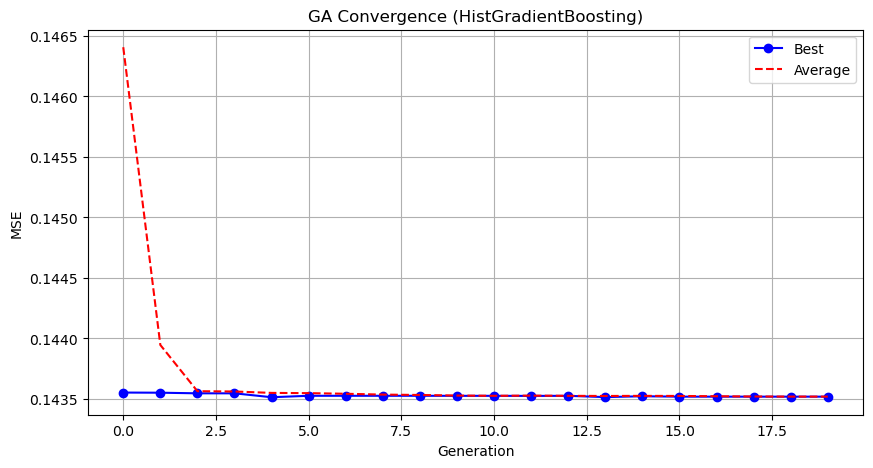

Genetic Algorithm completed successfully with MSE: 0.1435

Running Particle Swarm Optimization with HistGradientBoosting...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 50 features
- Target: Minimize MSE using HistGradientBoosting

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.149244
Best after iteration 1: [0.66434618 0.8171808  0.04639513 0.33745131 0.76468807 0.545534
 0.69349769 0.49870418 0.94468081 0.92369889 0.21113893 0.84332957
 0.6166403  0.22465975 0.79465728 0.17445014 0.93084809 0.06747911
 0.08231057 0.70444435 0.52670842 0.05078128 0.01662394 0.98778273
 0.04496639 0.03688785 0.79664965 0.21653062 0.45729016 0.3955064
 0.64680926 0.92459433 0.32674184 0.87520348 0.60978187 0.62155306
 0.93817069 0.07486706 0.42011648 0.11393981 0.00708341 0.38554322
 0.7541852  0.0034855  0.44074471 0.30701979 0.5791994  0.2825

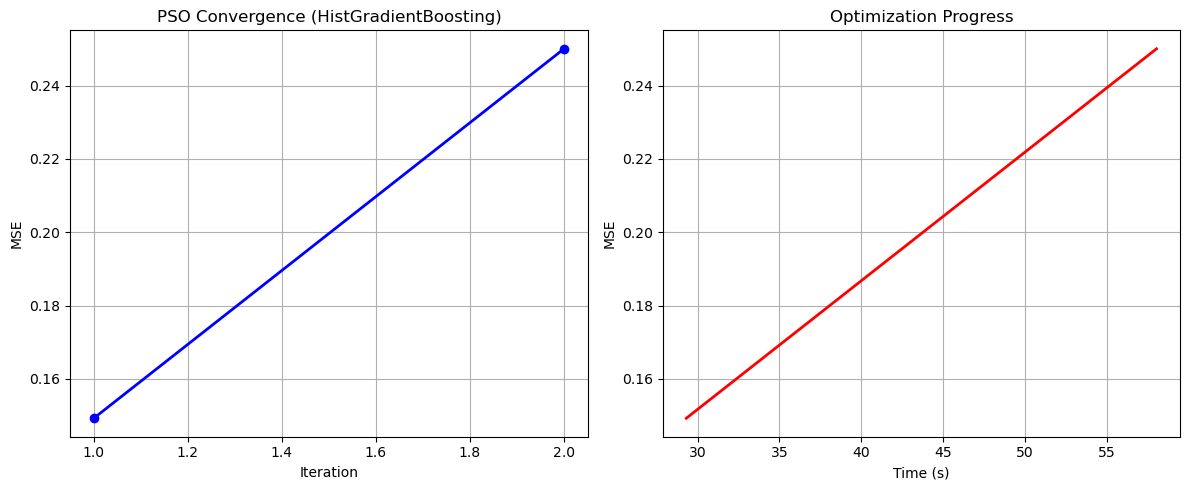

Particle Swarm Optimization completed successfully with MSE: 0.1435

Running Whale Optimization with HistGradientBoosting...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 50 features
- Target: Minimize MSE using HistGradientBoosting

[Optimization Progress]
Iter 20/20 | Best MSE: 0.143537

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143537
▶ Time elapsed: 726.18 seconds
▶ Features selected: 30/50 (40.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. LoanAmount
4. LoanDuration
5. Age
6. EmploymentStatus
7. MaritalStatus
8. EducationLevel
9. MonthlyDebtPayments
10. CreditCardUtilizationRate
11. NumberOfOpenCreditLines
12. NumberOfCreditInquiries
13. LoanPurpose
14. PreviousLoanDefaults
15. RetirementAccountBalance
16. TotalAssets
17. NetWorth
18. MortgageBalance
19. RentPayments
20. AutoLoanBalance
21. StudentLoanBalance
22. LifeInsuranceStatus
23. CarInsuranc

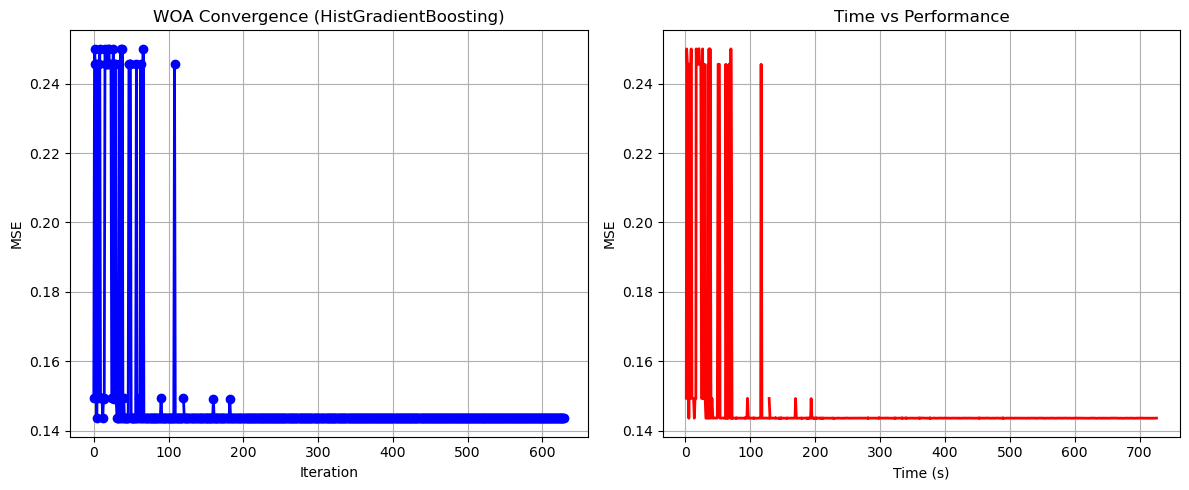

Whale Optimization completed successfully with MSE: 0.1435

Running Squid Game Optimizer with HistGradientBoosting...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 50 features
- Target: Minimize MSE using HistGradientBoosting


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143520
▶ Time elapsed: 698.65 seconds
▶ Features selected: 22/50 (56.0% reduction)

▶ Selected features:
1. CreditScore
2. AnnualIncome
3. Age
4. NumberOfDependents
5. HomeOwnershipStatus
6. NumberOfCreditInquiries
7. DebtToIncomeRatio
8. BankruptcyHistory
9. InterestRate
10. SavingsAccountBalance
11. RetirementAccountBalance
12. AutoLoanBalance
13. PersonalLoanBalance
14. StudentLoanBalance
15. UtilityBillsPaymentHistory
16. HomeInsuranceStatus
17. EmployerType
18. JobTenure
19. MonthlySavings
20. AnnualExpenses
21. MonthlyFoodCosts
22. MonthlyEntertainmentCosts

▶ Convergence progress:
- Initial MSE: 0.1436
- Final MSE: 0.1435

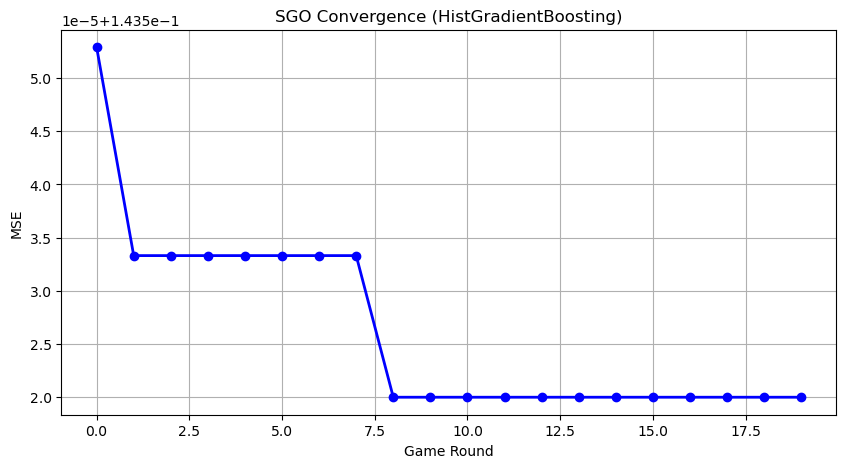

Squid Game Optimizer completed successfully with MSE: 0.1435

Running PSH-Hyptrite with HistGradientBoosting...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 50 features
- Target: Minimize MSE using HistGradientBoosting

[Optimization Progress]
Iter 20/20 | Best MSE: 0.143530 | Radius: 0.0250

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.143530
▶ Time elapsed: 2022.62 seconds
▶ Features selected: 23/50 (54.0% reduction)

▶ Selected features (with weights):
1. CreditScore (weight: 0.574)
2. AnnualIncome (weight: 0.741)
3. LoanDuration (weight: 0.962)
4. Age (weight: 0.783)
5. EmploymentStatus (weight: 0.537)
6. MaritalStatus (weight: 0.961)
7. EducationLevel (weight: 1.000)
8. HomeOwnershipStatus (weight: 0.975)
9. NumberOfOpenCreditLines (weight: 0.946)
10. PreviousLoanDefaults (weight: 0.985)
11. CheckingAccountBalance (weight: 0.541)
12. Retireme

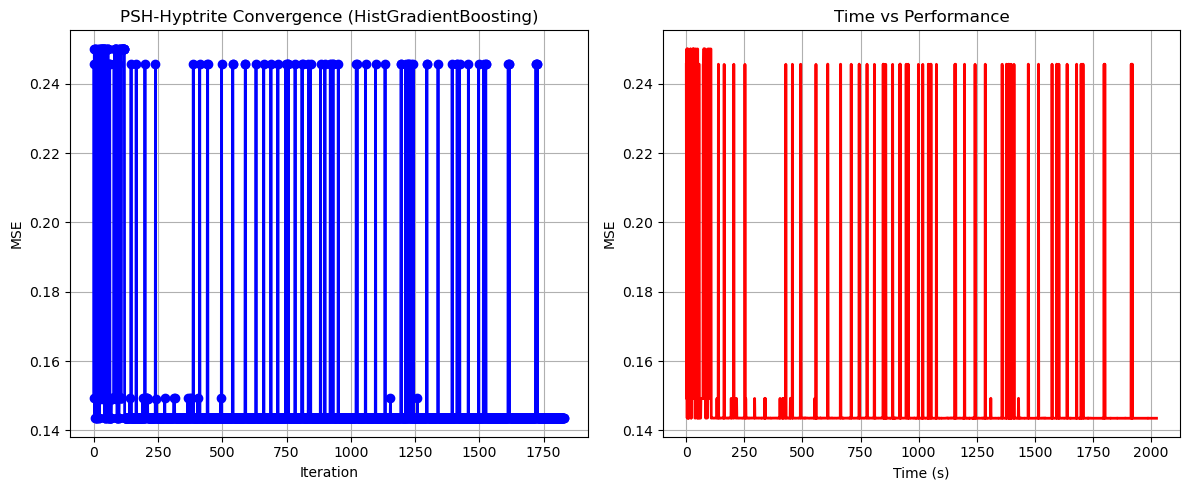

PSH-Hyptrite completed successfully with MSE: 0.1435


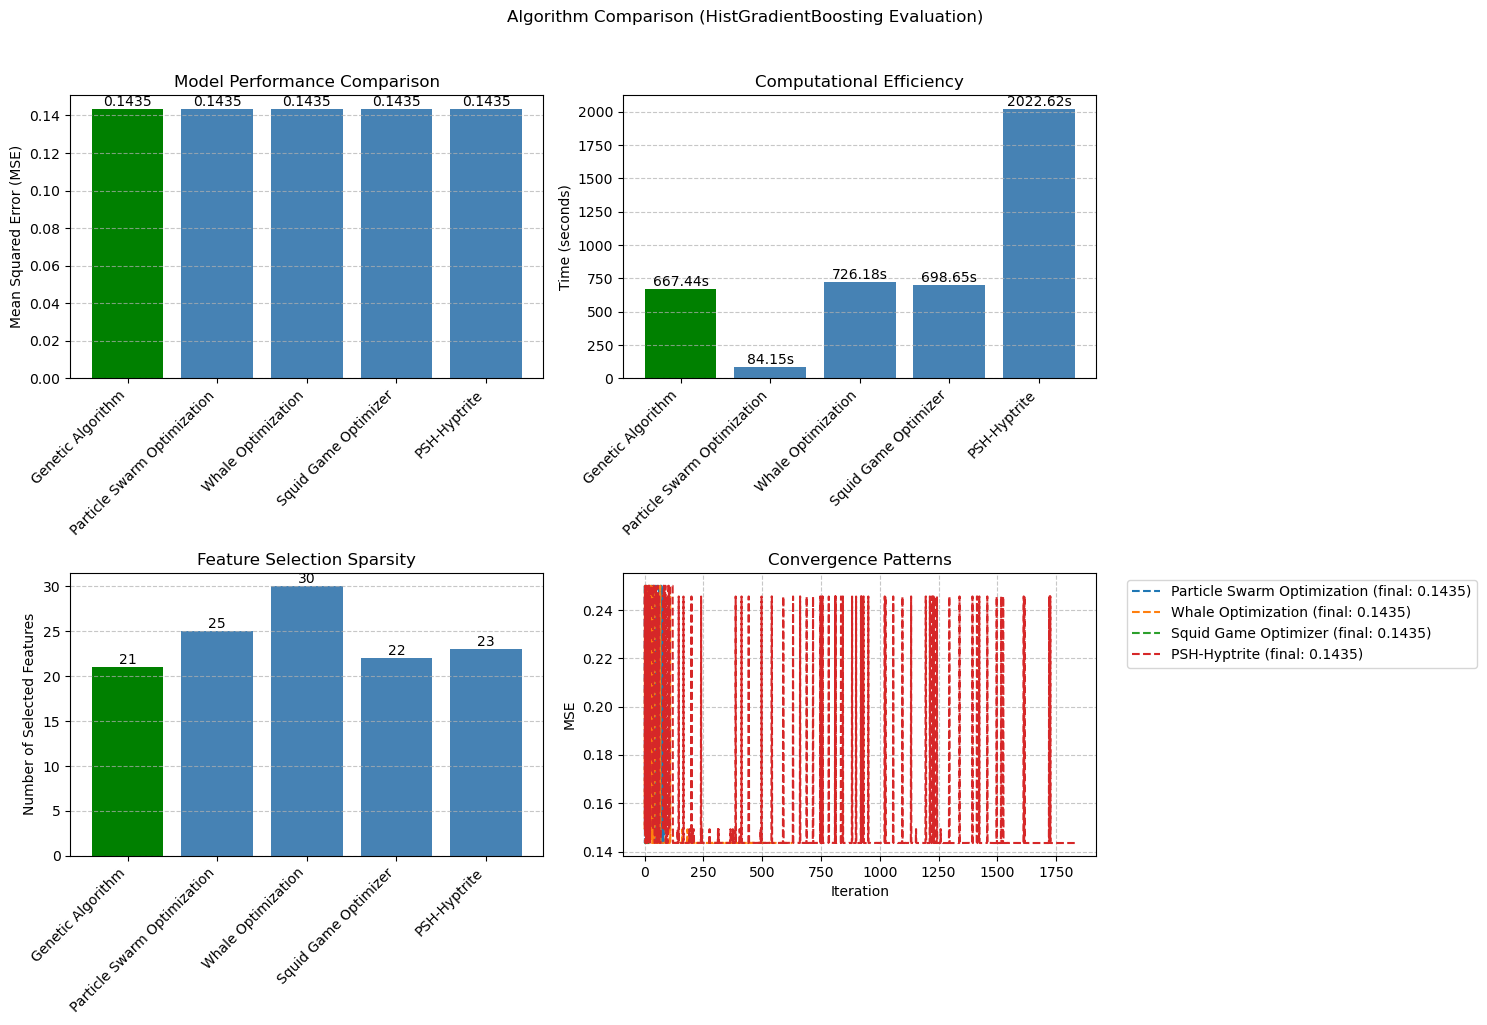


=== FINAL FEATURE SELECTION RESULTS USING HistGradientBoosting ===

🏆 BEST ALGORITHM: GENETIC ALGORITHM
   • MSE: 0.143515
   • Time: 667.44 seconds
   • Features: 21/50 (58.0% reduction)

📊 COMPARISON TABLE:
Algorithm                     MSE            Time (s)       Features       
---------------------------------------------------------------------------
Genetic Algorithm             0.143515       667.44         21             
Squid Game Optimizer          0.143520       698.65         22             
PSH-Hyptrite                  0.143530       2022.62        23             
Whale Optimization            0.143537       726.18         30             
Particle Swarm Optimization   0.143547       84.15          25             

🔍 SELECTED FEATURES:
1. CreditScore
2. AnnualIncome
3. LoanDuration
4. Age
5. NumberOfOpenCreditLines
6. DebtToIncomeRatio
7. InterestRate
8. PaymentHistory
9. SavingsAccountBalance
10. RetirementAccountBalance
11. EmergencyFundBalance
12. TotalAssets
13. R

In [182]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)